# Data Preprocess 3

This journal explains how to filter the recycling plants candidate locations according to Energy Justice metrics, leveraging [EJScreen: Environmental Justice Screening and Mapping Tool](https://www.epa.gov/ejscreen), more specifically, we will be using [EJScreen Report API](https://ejscreen.epa.gov/mapper/ejscreenapi.html).

## 0. Load necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
from pathlib import Path

import requests # to get api data

## 1. Load the file to filter and add FIPS codes

EJScreen API needs FIPS codes to access the EJ reports. So the first step is to load the file we want to use, in our case 'RELOG_import_data/CandidateLocations_CA.csv'.

In [26]:
candidates_raw = pd.read_csv('RELOG_import_data/CandidateLocations_CA.csv')
candidates_lat_long = candidates_raw.drop(['name', 'area cost factor'], axis=1, inplace= False)

In [27]:
candidates_lat_long

,latitude (deg),longitude (deg)
0,33.5854,-84.3778
1,36.3928,-103.0490
2,34.3336,-108.4771
3,35.2784,-107.9850
4,39.3646,-76.6158
...,...,...
91,42.0537,-87.9100
92,44.6412,-104.0558
93,45.4279,-108.5339
94,32.2724,-99.0110


In [33]:
fips_county_codes = []
fips_state_codes = []

In [34]:
# Code from https://gis.stackexchange.com/questions/294641/python-code-for-transforming-lat-long-into-fips-codes
import requests
import urllib

#Encode parameters 
for lat, lon in candidates_lat_long.itertuples(index=False):
    params = urllib.parse.urlencode({'latitude': lat, 'longitude':lon, 'format':'json'})
    #Contruct request URL
    url = 'https://geo.fcc.gov/api/census/block/find?' + params

    #Get response from API
    response = requests.get(url)

    #Parse json in response
    data = response.json()
    fips_county_codes.append(data['County']['FIPS'])
    fips_state_codes.append(data['State']['FIPS'])
    #Print FIPS code

In [37]:
candidates_lat_long['fips_county'] = fips_county_codes
candidates_lat_long['fips_state'] = fips_state_codes

Let's reshape the dataframe to have the names back and all the  EJ indices in the dataframe related to the fips codes.

In [60]:
ej_candidates = candidates_lat_long.copy()

In [62]:
ej_candidates['name'] = candidates_raw['name']

Now, I am going to query a random fips code to get the column names.

In [66]:
ej_query = requests.get(f'https://ejscreen.epa.gov/mapper/ejscreenRESTbroker.aspx?namestr=Pickens County&geometry=&distance=&unit=9035&areatype=county&areaid=35003&f=pjson')
ej_query_keys = [keys for keys in ej_query.json().keys()]

In [68]:
ej_candidates[ej_query_keys] = np.nan

/var/folders/w2/85_h_nyn0mlbxf81x3k9n53xh90n_1/T/ipykernel_80367/2673602796.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ej_candidates[ej_query_keys] = np.nan
/var/folders/w2/85_h_nyn0mlbxf81x3k9n53xh90n_1/T/ipykernel_80367/2673602796.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ej_candidates[ej_query_keys] = np.nan
/var/folders/w2/85_h_nyn0mlbxf81x3k9n53xh90n_1/T/ipykernel_80367/2673602796.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

In [76]:
ej_query_values = [value for value in ej_query.json().values()]

In [87]:
ej_candidates.loc[ej_candidates['fips_county'] == '35003', 'RAW_D_MINOR':] = ej_query_values

In [89]:
ej_candidates.loc[ej_candidates['fips_county'] == '35003', 'RAW_D_MINOR':]

,RAW_D_MINOR,RAW_D_INCOME,RAW_D_LESSHS,RAW_D_LING,RAW_D_UNDER5,RAW_D_OVER64,RAW_D_UNEMPLOYED,RAW_D_INDEX,RAW_E_LEAD,RAW_E_DIESEL,...,statLayerCount,statLayerZeroPopCount,weightLayerCount,timeSeconds,distance,unit,areaid,areatype,statlevel,inputAreaMiles
2,17%,53%,7%,2%,2%,42%,5%,35%,0.14,0.0102,...,5,0,0,0.1769966,0,9035,35003,county,blockgroup,6929.63


In [90]:
ej_candidates[ej_query_keys][ej_candidates['fips_county'] == '35003']

,RAW_D_MINOR,RAW_D_INCOME,RAW_D_LESSHS,RAW_D_LING,RAW_D_UNDER5,RAW_D_OVER64,RAW_D_UNEMPLOYED,RAW_D_INDEX,RAW_E_LEAD,RAW_E_DIESEL,...,statLayerCount,statLayerZeroPopCount,weightLayerCount,timeSeconds,distance,unit,areaid,areatype,statlevel,inputAreaMiles
2,17%,53%,7%,2%,2%,42%,5%,35%,0.14,0.0102,...,5,0,0,0.1769966,0,9035,35003,county,blockgroup,6929.63


In [91]:
for fips in fips_list:
    ej_query = requests.get(f'https://ejscreen.epa.gov/mapper/ejscreenRESTbroker.aspx?namestr=Pickens County&geometry=&distance=&unit=9035&areatype=county&areaid={fips}&f=pjson')
    ej_query_values = [value for value in ej_query.json().values()]
    ej_candidates.loc[ej_candidates['fips_county'] == f'{fips}', 'RAW_D_MINOR':] = ej_query_values
    



There are some percentages values that prevent me from making these numbers floats, so I am going to get rid of the %, I know what is percentage and what is percentile based on the 'EJ_json_dictionary_help.xlsx' file in the folder 'miscellaneous', you can also see a sample of these values from the EJ report screen capture [here](miscellaneous/json_variables_explained.png).

In [100]:
ej_candidates = ej_candidates.replace({'%':''}, regex=True)
ej_candidates = ej_candidates.replace('N/A',np.nan)

In [121]:
ej_candidates.loc[:, 'RAW_D_MINOR':'N_P_UST'] = ej_candidates.loc[:, 'RAW_D_MINOR':'N_P_UST'].astype(float)
ej_candidates.loc[:, 'totalPop':'areaid'] = ej_candidates.loc[:, 'totalPop':'areaid'].astype(float)

In [122]:
ej_candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Columns: 146 entries, latitude (deg) to inputAreaMiles
dtypes: float64(137), object(9)
memory usage: 109.6+ KB


In [116]:
ej_candidates['name']

0        Clayton, Georgia
1       Union, New Mexico
2      Catron, New Mexico
3      Cibola, New Mexico
4     Baltimore, Maryland
             ...         
91         Cook, Illinois
92         Crook, Wyoming
93      Big Horn, Montana
94        Eastland, Texas
95    Champaign, Illinois
Name: name, Length: 96, dtype: object

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (96,) and arg 1 with shape (2,).

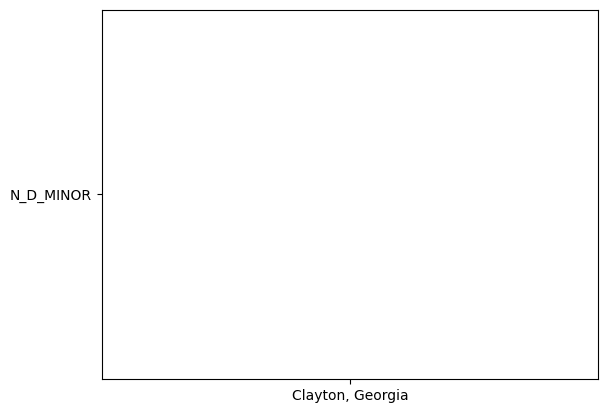

In [132]:
plt.bar("name", ("N_D_MINOR", "N_D_MINOR_PER"), data = ej_candidates)
plt.xlabel("County")
plt.ylabel("Population")
#plt.title("")
plt.show()

In [129]:
ej_candidates['N_D_MINOR_PER']

0     89.0
1     66.0
2     35.0
3     84.0
4     80.0
      ... 
91    72.0
92    16.0
93    80.0
94    41.0
95    54.0
Name: N_D_MINOR_PER, Length: 96, dtype: float64